## Code to attempt to build the Semeter, Kamalabadi 2005 inversion model in python

written by Riley Troyer fall 2021

In [1]:
# Libraries
from datetime import datetime as dt
import h5py
from matplotlib import pyplot as plt
from matplotlib import colors
import msise00
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

## Functions used in program

In [2]:
def get_msis_density(run_time, altitudes_z, max_alt=1001e3,
                     glat=65.117, glon=212.540):
    """Function to get MSIS calculated atmospheric densities.
    DEPENDENCIES
        msise00, numpy, scipy.interpolate.interp1d
    INPUT
    run_time
        type: datetime
        about: time to run msis code for
    altitudes
        type: array of floats
        about: altitudes in meters to run msis code for
    max_alt = 1001e3
        type: float
        about: maximum altitude in meters to run msis for. 
               Function creates a high altitude log spaced array
               between the max of altitudes and the max_alt value.
               This is primarily for approximating an indefinite integral.
    OUTPUT
    total_msis_alt
        type: array of floats
        about: altitudes values in meters including original array and
               high altitude array
    msis_interp_density
        type: scipy.interplate function
        about: 1d interpolation of msis density spanning entire altitude
               range.
    """
    
    # Run msis for lower altitudes
    msis_run_low = msise00.run(time=run_time, altkm=altitudes_z/1000,
                               glat=pfrr_lat, glon=pfrr_lon)

    # Define a higher altitude array
    msis_alt_high = np.logspace(np.log10(max(altitudes_z)+1),
                                np.log10(max_alt), 20)
    
    # Run msis for these higher altitudes
    msis_run_high = msise00.run(time=run_time, altkm=msis_alt_high/1000,
                               glat=pfrr_lat, glon=pfrr_lon)

    # Get total density data
    msis_density_low = msis_run_low['Total'].data[0, :, 0, 0]
    msis_density_high = msis_run_high['Total'].data[0, :, 0, 0]

    # Combine altitude and densities from low and high altitudes
    total_msis_alt = np.concatenate((altitudes_z, msis_alt_high))
    total_msis_density = np.concatenate((msis_density_low,
                                         msis_density_high))

    # Create a scipy interpolation function to define density v. altitude
    msis_interp_density = interp1d(total_msis_alt, total_msis_density)
    
    return total_msis_alt, msis_interp_density

def barrett_hays_range_energy_func(K):
    """Function to define mass range of electron in air for a specific
    energy K in eV. From Barett & Hays 1976
    INPUT
    K
        type: float
        about: energy of electron in eV
    OUTPUT
    R
        type: float
        about: mass range of particle in kg m^-2 
    """
    # Convert energy to keV to match formula
    K = K/1000
    
    # Range function
    R = 4.3e-7 + 5.36e-6 * K**(1.67) - 0.38e-8 * K**(-0.7)
    
    # Convert R from g/cm^2 to kg/m^2
    R = R * 10
    
    return R

def mass_distance(z_i, I=0):
    """Function to mass distance of particle traveling some distance
    into the atmosphere. Denoted s in the derivations.
    Using trapezoid rule for this, which seems to be good enough
    INPUT
    z
        type: int
        about: index of altitude that particle reached to
    I=0
        type: float
        about: angle of magnetic inclination at measuring site in radians
    OUTPUT
    s
        type: float
        about: mass distance in kg m^-2
    """
    
    # Calculate mass distance traveled 
    s = (1/np.cos(I)) * trapezoid(total_msis_density[z_i:],
                                  total_msis_alt[z_i:])
    
    return s

def recombination_coeff(z):
    """Function defining recombination coefficient
    INPUT
    z
        type:float
        about: altitude in kilometers
    OUTPUT
    alpha
        type: float
        about: recombination coefficient in m^3/s
    """
    
    alpha = 2.5e-12 * np.exp(-z/51.2)
    
    return alpha

## Things used in rest of code

In [4]:
# Get location of PFISR
pfrr_lat = 65.117
pfrr_lon = 212.540

# Define test flux in m^-2 s^-1
F = 1e12

# Don't use PFISR data below this altitude in km
pfisr_min_alt = 50

# Define arrays for altitude and energy bins

# Altitude in meters
#...number of points should be around the same as pfisr data
altitudes_z = np.linspace(50e3, 140e3, 100)

# Energies in eV
#...should probably be less than altitude bins to avoid overfitting
energies_K = np.logspace(np.log10(300), np.log10(300000), 50)

## I'll start by reading in all of the datafiles we need

### First ISR data

In [5]:
# Path to pfisr data directory
pfisr_data_dir = ('../source-energy-pa/data/pfisr-data/mswinds')

# Get a list of all pfisr data files
pfisr_files = [f for f in os.listdir(pfisr_data_dir) 
               if f.endswith('.h5')]

# Sort by date
pfisr_files = sorted(pfisr_files)

pfisr_filename = pfisr_files[12]

# Read in the h5 file
pfisr_file = h5py.File(pfisr_filename, 'r')

# Get the different beams and select specified angle
beam_angle = 90
beams = np.array(pfisr_file['BeamCodes'])

# Get the beam with a 90 degree elevation angle
indexes = np.linspace(0, len(beams)-1, len(beams))
beam_num = int(indexes[np.abs(beams[:,2] - beam_angle) == 0][0])

# Get time and convert to utc datetime
unix_time = np.array(pfisr_file['Time']['UnixTime'])[:,0]
utc_time = np.array([dt.utcfromtimestamp(d) for d in unix_time])

# Get the altitude array
pfisr_altitude = np.array(pfisr_file['NeFromPower']
                          ['Altitude'])[beam_num, :]

# Convert to kilometers
pfisr_altitude = pfisr_altitude

# Get the uncorrected number density array
e_density = np.array(pfisr_file['NeFromPower']
                     ['Ne_NoTr'])[:, beam_num, :]

# Filter it assuming data outside of range is bad
low_cutoff = 0
high_cutoff=1e12
e_density[e_density < low_cutoff] = 0.0
e_density[e_density > high_cutoff] = 0.0

# Take the transpose
e_density = np.transpose(e_density)

# Get error values
de_density = np.array(pfisr_file['NeFromPower']
                      ['errNe_NoTr'])[:, beam_num, :]
de_density = np.transpose(de_density)

# Close file
pfisr_file.close()

### Next file defining $\Lambda$ function

In [6]:
# Read in file with energy dissipation function
lambda_filename = 'semeter_kamalabadi_lambda_function.txt'
lambda_data = np.loadtxt(lambda_filename, skiprows=5)

# Create an interpolated function from this
#...values outside set to 0
lambda_interp = interp1d(lambda_data[:, 0], lambda_data[:, 1],
                         bounds_error=False, fill_value=0)

In [21]:
# Create a dictionary to store inversion results in
inversion_results = {}

## Start running
### start by getting MSISE00 calculated density values

In [8]:
slice_n = 150

run_time = utc_time[slice_n]

In [10]:
# Get MSIS calculated densities
(total_msis_alt,
 msis_interp_density) = get_msis_density(run_time, altitudes_z,
                                         max_alt=1001e3,
                                         glat=pfrr_lat, glon=pfrr_lon)

# Get density for altitude bins
total_msis_density = msis_interp_density(total_msis_alt)
density_rho = msis_interp_density(altitudes_z)

## Next we need to calculate the ion production rate. This depends on the specific atmospheric density.

### $q(z, K) = \frac{\Lambda \rho K F}{35.5 R} $

where K is the energy of an electron in eV. F is the flux, which we'll take to be $1 \times 10^{12} \, \text{m}^{-2} \cdot \text{s}^{-1}$, $R$ is the range-energy function, and $\Lambda$ is a universal energy dissipation function. $\Lambda$ values for an isotropic beam are given in the paper.

### $\Lambda$ is a function of $s/R$, where $s = \frac{1}{\cos(I)} \int_{0}^{\infty} \rho(z)\, dz$, the mass distance a particle travels through. Here I assume $I$ the incident angle of the particles is 0. $R$ is the range-energy function from Barett & Hays 1976.

Values for $\Lambda$ are defined in the paper

In [11]:
# Calculate mass distance (s) for each altitude by integrating
#...out to 1000 km (~infinity)
s = np.array([mass_distance(z) for z in range(len(altitudes_z))])

# Calculate ion production rate for each energy and store in dictionary
ion_prod_rate = {}

for i, energy in enumerate(energies_K):
    
    # Calculate range-energy value
    R = barrett_hays_range_energy_func(energy)
    
    # Get the (s/R)(z) for the energy
    s_R = s/R
    
    # Use s/R to get Lambda function values
    lambda_vals = lambda_interp(s_R)
    
    # Use all of this to calculate ion production rate as function of alt
    q = (lambda_vals * density_rho * energy * F) / (35.5 * R)
    
    # Write to dictionary
    ion_prod_rate[energy] = q

## Now that we have ion production rate as a function of energy and altitude, our next step is to construct the A matrix such that
### $\bf{q} = \bf{A} \phi$
### each column of A is just q(z) for a specific energy multiplied by the energy bin width 

In [12]:
# Construct the A matrix
matrix_A = np.zeros([len(altitudes_z), len(energies_K)])

# Loop through each energy value
for j in range(len(energies_K)):
    
    # Get the size of the energy bin
    #...first bin is from zero to energy
    if j == 0:
        delta_E = energies_K[j] - 0
    else:
        delta_E = energies_K[j] - energies_K[j-1]
        
    # Set column of matrix
    matrix_A[:, j] = ion_prod_rate[energies_K[j]] * (delta_E/F)

## With A created we can now use the ISR data to get an estimate of $q(z)$, assuming that $q = \alpha n^2 + \frac{dn}{dt}$ and that $\frac{dn}{dt}$ is negligible.

In [13]:
# Read in density and errors in those measurements for specific time
e_density_slice = e_density[:, slice_n]
de_density_slice = de_density[:, slice_n]

# Only take value above 50 km, below data can be off
e_density_slice = e_density_slice[pfisr_altitude > pfisr_min_alt]

de_density_slice = de_density_slice[pfisr_altitude > pfisr_min_alt]


# Make an interpolation model of this data with respect to altitude
#...but only do this for altitudes > defined minimum value,
#...below this data can be weird
pfisr_density_interp = interp1d(pfisr_altitude[pfisr_altitude
                                               > pfisr_min_alt],
                                e_density_slice[pfisr_altitude
                                                > pfisr_min_alt])

# Same interpolation except for error in density
pfisr_error_interp = interp1d(pfisr_altitude[pfisr_altitude
                                             > pfisr_min_alt],
                              de_density_slice[pfisr_altitude
                                               > pfisr_min_alt])

In [14]:
# Calculate all recombination coeffcients
alphas = np.array([recombination_coeff(z/1000) for z in altitudes_z])

# Multiply by pfisr density to get an estimate of ion production rate
q_estimate = alphas * pfisr_density_interp(altitudes_z)**2

# Get error dq = 2*alpha*n*dn
dq_estimate = (2 * alphas * pfisr_density_interp(altitudes_z)
               * pfisr_error_interp(altitudes_z))

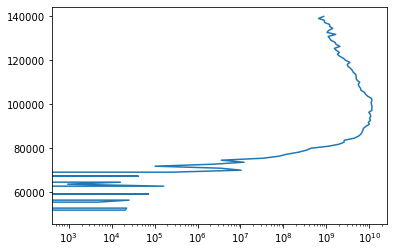

In [15]:
plt.plot(q_estimate, altitudes_z)
plt.xscale('log')

## To make an initial guess of the number flux of each energy bin, I assume a flux of $1 \times 10^{12}$ m$^{-2}$s $^{-1}$ spread equally over all bins and divided by the width of each bin. 

### I also assume if the column of A associated with the energy bin is all zero then the flux for that bin is zero.

In [16]:
# Make an initial guess of the number flux
initial_num_flux = np.ones(len(energies_K))*(1e12/len(energies_K))

# Divide by energy bin widths
bin_widths = energies_K - np.roll(energies_K, shift=1)

# Fix first value
bin_widths[0] = energies_K[0] - 0

# Set initial guess
initial_num_flux = initial_num_flux/bin_widths

# If full column of A matrix is zero set initial flux to zero
for j in range(len(energies_K)):
    
    if np.sum(matrix_A[:, j]) == 0:
        initial_num_flux[j] = 0

## Given all this we can now run the maximum entropy method iterations

Note: this will cause some warnings due to dividing by 0. I account for the associated undefined values in the code.

In [17]:
# Set previous value to initial at start
old_num_flux = initial_num_flux
new_num_flux = np.zeros(len(initial_num_flux))

# Create array to store all minimum j values
min_js = np.zeros(len(altitudes_z), dtype=int)

# Find all nonzero indices of A matrix
nonzero_args = np.argwhere(matrix_A > 0)

for i in range(len(min_js)):

    non_zeros = nonzero_args[nonzero_args[:, 0] == i]

    # If there are no non zero values in row, then set to first instance
    if len(non_zeros) == 0:
        min_js[i] = 0

    # Otherwise find the minimum j
    else:
        min_js[i] = min(non_zeros[:, 1])
        
# Find the index past which A is defined for altitudes
good_alt_index = np.argwhere(min_js>0)[0][0]

# Run interations until chi2 < 1.5
reduced_chi_square = 10

# Or count < specified amount
count = 0

while (reduced_chi_square > 1.5):    

    # Check count
    if count > 10000:
        print('Max iterations reached with chi2 = ', reduced_chi_square)
        break
    
    # Construct the t vector
    t = 1/np.dot(matrix_A[:, min_js], old_num_flux[min_js])

    # Adjust for infinite values in regions without a nonzero j
    t[t == np.inf] = 0        

    for j in range(len(energies_K)):

        # Construct c vector
        frac = np.inner(matrix_A, old_num_flux)/q_estimate
        c = 20 * (1 - frac) * t

        # Account for nan and infinite values
        #...this is why warning is raised
        c[np.isnan(c)] = 0
        c[c == -np.inf] = 0
        c[c == np.inf] = 0

        # Define w constant
        w = np.ones(len(altitudes_z))/len(altitudes_z)

        # Summation of matrix elements
        i_sum = np.sum(w*c*matrix_A[:, j])

        # New guess
        new_num_flux[j] = old_num_flux[j]/(1 - old_num_flux[j] * i_sum)

    # Check chi squared, but only on altitudes that A is defined for
    diff = q_estimate - np.dot(matrix_A, new_num_flux)
    chi_square_array = diff**2/dq_estimate**2
    
    # Set undefined values to zero
    chi_square_array[np.isnan(chi_square_array)] = 0
    chi_square_array[chi_square_array == np.inf] = 0
    chi_square_array[chi_square_array == -np.inf] = 0
    
    # Get the chi squared value
    chi_square = np.sum(chi_square_array)
    
    # And the reduced chi square, which should be around 1
    reduced_chi_square = chi_square/(len(diff[good_alt_index:])-1)

    # Set old value to new
    old_num_flux = np.copy(new_num_flux)
    
    # Set count
    count = count + 1
    
print('Convergence reached. Iterations: ', count-1)

Convergence reached. Iterations:  33


/tmp/ipykernel_3604984/1513624580.py:40: RuntimeWarning: divide by zero encountered in true_divide
  t = 1/np.dot(matrix_A[:, min_js], old_num_flux[min_js])
/tmp/ipykernel_3604984/1513624580.py:48: RuntimeWarning: divide by zero encountered in true_divide
  frac = np.inner(matrix_A, old_num_flux)/q_estimate
/tmp/ipykernel_3604984/1513624580.py:48: RuntimeWarning: invalid value encountered in true_divide
  frac = np.inner(matrix_A, old_num_flux)/q_estimate
/tmp/ipykernel_3604984/1513624580.py:68: RuntimeWarning: divide by zero encountered in true_divide
  chi_square_array = diff**2/dq_estimate**2
/tmp/ipykernel_3604984/1513624580.py:68: RuntimeWarning: invalid value encountered in true_divide
  chi_square_array = diff**2/dq_estimate**2


In [23]:
# Write data to dictionary
d = {'altitude_m' : altitudes_z,
     'modeled_density' : np.sqrt(np.dot(matrix_A,
                                           new_num_flux)/alphas),
     'measured_density' : pfisr_density_interp(altitudes_z),
     'energy_bins' : energies_K,
     'modeled_flux' : new_num_flux,
     'reduced_chi2' : reduced_chi_square,
     'units' : 'Values given in meters, seconds, electron-volts.'
    }

inversion_results[run_time] = d

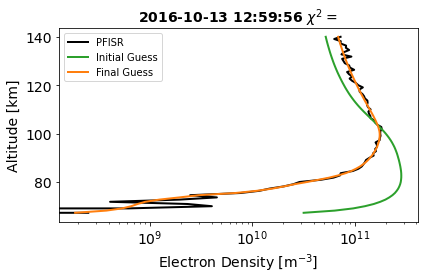

In [39]:
# For vizualization purposes convert back to electron density
#...this is easy since we assumed q = alpha * n^2
pfisr_density_plot = pfisr_density_interp(altitudes_z)[good_alt_index:]
initial_guess_plot = np.sqrt(np.dot(matrix_A,
                                    initial_num_flux)
                             /alphas)[good_alt_index:]
final_guess_plot = np.sqrt(np.dot(matrix_A,
                                  new_num_flux)
                           /alphas)[good_alt_index:]

# Plot figure of initial guess, real data and fit
fig, ax = plt.subplots()

# Titles and axis labels
ax.set_title(str(utc_time[slice_n]) + r' $\chi^2=$',
             fontsize=14, fontweight='bold')

ax.set_ylabel('Altitude [km]', fontsize=14)
ax.set_xlabel(r'Electron Density [m$^{-3}$]', fontsize=14)

# Axis
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.set_xscale('log')

# Plot PFISR data
ax.plot(pfisr_density_plot, altitudes_z[good_alt_index:]/1000,
        color='k', linewidth=2, label = 'PFISR')

# Plot initial guess
ax.plot(initial_guess_plot, altitudes_z[good_alt_index:]/1000,
        color='C2', linewidth=2, label = 'Initial Guess')

# Plot final guess
ax.plot(final_guess_plot, altitudes_z[good_alt_index:]/1000,
        color='C1', linewidth=2, label = 'Final Guess')

plt.legend()

plt.tight_layout()

#plt.savefig('semeter-inversion-test-q-2.jpg', dpi=150)

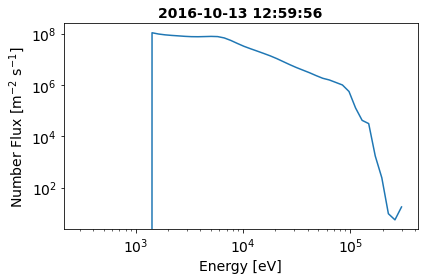

In [20]:
# Plot figure of initial guess, real data and fit
fig, ax = plt.subplots()

# Titles and axis labels
ax.set_title(str(utc_time[n]),
             fontsize=14, fontweight='bold')

ax.set_ylabel(r'Number Flux [m$^{-2}$ s$^{-1}$]', fontsize=14)
ax.set_xlabel('Energy [eV]', fontsize=14)

# Axis
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.set_xscale('log')
ax.set_yscale('log')

# Plot the energy
ax.plot(energies_K, new_num_flux)

plt.tight_layout()

#plt.savefig('semeter-inversion-test-numflux-2.jpg', dpi=150)

In [35]:
print('Slice: {slice_n}. '
      'Unable to converge. '
      'Max iterations reached with chi2 = {chi2}'
      .format(slice_n=slice_n,
              chi2=round(reduced_chi_square, 2)))

Slice: 150. Unable to converge. Max iterations reached with chi2 = 1.49
